In [1]:
from mfglib.env import Environment
from mfglib.alg.utils import _ensure_free_tensor,tuple_prod
from mfglib.mean_field import mean_field
from typing import Literal, cast
import torch
from mfglib.alg.greedy_policy_given_mean_field import Greedy_Policy
import matplotlib.pyplot as plt
from mfglib.alg import MFOMO,PriorDescent, FictitiousPlay,OnlineMirrorDescent, TwoScaleLearning
from mfglib.metrics import exploitability_score
from mfglib.alg.q_fn import QFn
import scipy
#import scienceplots
#plt.style.use(['science','no-latex'])
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from tqdm import tqdm

d:\Program Files\anaconda3\envs\mfg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [47]:
T = 10
exp_name = 'SIS'

import os
if not os.path.exists(f'results/{exp_name}'):
    os.makedirs(f'results/{exp_name}')

### Run two scale learning

In [15]:
env_instance = Environment.susceptible_infected(T = T)
solns, solns_mu, expls, diffs, runtimes = TwoScaleLearning(Q_speed = 0.55, mu_speed=1).solve(env_instance, max_iter=50000, verbose=True)
torch.save(solns, "results/SIS/pi_record.pt")
torch.save(solns_mu, "results/SIS/nu_record.pt")
torch.save(expls, "results/SIS/exp_record.pt")
torch.save(diffs, "results/SIS/diff_record.pt")
torch.save(runtimes, "results/SIS/time_record.pt")


            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(2,)
	A(2,)
	T=10
	r_max=1.5

Algorithm summary:
	OnlineMirrorDescent(Q_speed=0.55, mu_speed=1)
	atol=0.001
	rtol=0.001
	max_iter=50000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 1.60624  |     1.00000     |          0           |  0.000   |
|  1   | 1.19248  |     0.74240     |          1           |  0.010   |
|  2   | 1.03363  |     0.64351     |          2           |  0.020   |
|  3   | 0.93595  |     0.58269     |          3           |  0.029   |
|  4   | 0.86604  |     0.53917     |          4           |  0.037   |
|  5   | 0.80365  |     0.50033     |          5           |  0.046   |
|  6   | 0.74689  |     0.46499     |         

### Run OMD

In [16]:
env_instance = Environment.susceptible_infected(T = T)
solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=50000, verbose=True)
torch.save(solns, f"results/{exp_name}/MFE_pi_record.pt")
torch.save(expls, f"results/{exp_name}/MFE_exp_record.pt")

            MFGLib v0.1.1 : A Library for Mean-Field Games             
                  (c) RADAR Research Lab, UC Berkeley                  

Environment summary:
	S=(2,)
	A(2,)
	T=10
	r_max=1.5

Algorithm summary:
	OnlineMirrorDescent(alpha=1.0)
	atol=0.001
	rtol=0.001
	max_iter=50000

-----------------------------------------------------------------------
| iter |  expl_n  | expl_n / expl_0 | argmin_{0..n} expl_i | time (s) |
-----------------------------------------------------------------------
|  0   | 1.60624  |     1.00000     |          0           |  0.000   |
|  1   | 1.21810  |     0.75836     |          1           |  0.011   |
|  2   | 0.93108  |     0.57966     |          2           |  0.020   |
|  3   | 0.71494  |     0.44510     |          3           |  0.032   |
|  4   | 0.55960  |     0.34839     |          4           |  0.038   |
|  5   | 0.44263  |     0.27557     |          5           |  0.046   |
|  6   | 0.35519  |     0.22113     |          6           | 

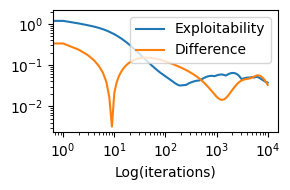

In [19]:
expls = torch.load(f"results/{exp_name}/exp_record.pt")[:10000]
diffs = torch.load(f"results/{exp_name}/diff_record.pt")[:10000]
plt.figure(figsize=(3, 2))
plt.plot(expls, label='Exploitability') 
plt.plot(diffs, label='Difference') 
plt.legend(loc='best')
#plt.grid(True)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Log(iterations)')
plt.tight_layout()

plt.savefig(f'results/{exp_name}/converge',dpi=300)

plt.show()

### CMFE vs MFE

In [51]:
env_instance = Environment.susceptible_infected(T = T)
solns = torch.load(f"results/{exp_name}/pi_record.pt")
IC = torch.load(f"results/{exp_name}/nu_record.pt")
pi = solns[10000]
nu = IC[10000]
env_instance.update_initial_distribution(nu)
L = mean_field(env_instance, pi)
print(L.shape)
mu = L.sum(dim=tuple(range(2, L.ndim)))
print(mu)
mu_np = mu.numpy()

torch.Size([11, 2, 2])
tensor([[0.4241, 0.5759],
        [0.5969, 0.4031],
        [0.7156, 0.2844],
        [0.6362, 0.3638],
        [0.7407, 0.2593],
        [0.6640, 0.3360],
        [0.5841, 0.4159],
        [0.5130, 0.4870],
        [0.4694, 0.5306],
        [0.4387, 0.5613],
        [0.4076, 0.5924]])


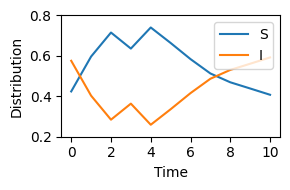

In [53]:
plt.figure(figsize=(3, 2))
plt.plot(mu_np[:,0], label='S')
plt.plot(mu_np[:,1], label='I')
plt.legend(loc='best')
plt.xticks([0,2,4,6,8,10])
plt.xlabel('Time')
plt.ylabel('Distribution')
plt.ylim(0.2, 0.8)
plt.tight_layout()

plt.savefig(f'results/{exp_name}/CMFE',dpi=300)
plt.show()

torch.Size([11, 2, 2])
tensor([[0.4000, 0.6000],
        [0.5800, 0.4200],
        [0.7060, 0.2940],
        [0.6261, 0.3739],
        [0.7383, 0.2617],
        [0.6603, 0.3397],
        [0.5805, 0.4195],
        [0.7063, 0.2937],
        [0.6308, 0.3692],
        [0.5529, 0.4471],
        [0.4868, 0.5132]])


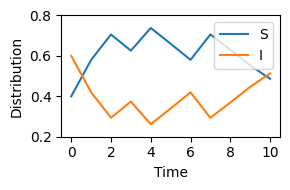

In [54]:
env_instance = Environment.susceptible_infected(T = T)
solns = torch.load(f"results/{exp_name}/MFE_pi_record.pt")
pi = solns[-1]
L = mean_field(env_instance, pi)
print(L.shape)
mu = L.sum(dim=tuple(range(2, L.ndim)))
print(mu)
mu_np = mu.numpy()

plt.figure(figsize=(3, 2))
plt.plot(mu_np[:,0], label='S')
plt.plot(mu_np[:,1], label='I')
plt.legend(loc='best')
plt.xticks([0,2,4,6,8,10])
plt.xlabel('Time')
plt.ylabel('Distribution')
plt.ylim(0.2, 0.8)
plt.tight_layout()
plt.savefig(f'results/{exp_name}/MFE',dpi=300)
plt.show()

### Contraction

In [55]:
def TV(nu, mu):
    """
    Compute the Total Variation distance between two distributions.
    """
    return torch.sum(torch.abs(nu - mu)) / 2.0

def TV_np(nu, mu):
    return np.sum(np.abs(nu - mu)) / 2.0

In [68]:
T = 15
s_inv = 1


In [69]:
torch.manual_seed(0)
max_iter = 200
ratio_record = []

for i in tqdm(range(max_iter)):
    nu1 = torch.rand(s_inv+1)
    nu1 = nu1 / nu1.sum()
    env_instance = Environment.susceptible_infected(T = T)
    env_instance.update_initial_distribution(nu1)
    solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    L = mean_field(env_instance, pi)
    mu = L.sum(dim=tuple(range(2, L.ndim)))
    mu_T1 = mu[-1]

    nu2 = torch.rand(s_inv+1)
    nu2 = nu2 / nu2.sum()
    env_instance = Environment.susceptible_infected(T = T)
    env_instance.update_initial_distribution(nu2)
    solns, expls, runtimes = OnlineMirrorDescent().solve(env_instance, max_iter=5000, verbose=False)
    pi = solns[-1]
    L = mean_field(env_instance, pi)
    mu = L.sum(dim=tuple(range(2, L.ndim)))
    mu_T2 = mu[-1]

    ratio = TV(mu_T1, mu_T2) / TV(nu1, nu2)
    ratio_record.append(ratio.item())


100%|██████████| 200/200 [6:23:31<00:00, 115.06s/it]  


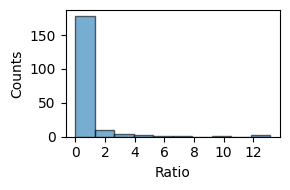

In [72]:
plt.figure(figsize=(3, 2))
plt.hist(ratio_record, bins=10, density=False, alpha=0.6, edgecolor='black')
plt.xlabel('Ratio')
plt.xticks([0,2,4,6,8,10,12])
plt.ylabel('Counts')
plt.tight_layout()
plt.savefig(f'results/{exp_name}/contraction_{T}.png',dpi=300)
